In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dataset import Dataset, DataLoader
from models import BertModel

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import re
import string

import os
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
os.listdir('data')

['snli_1.0_test.jsonl',
 'snli_1.0_dev.jsonl',
 'snli_1.0_train.jsonl',
 '.ipynb_checkpoints']

In [4]:
train_df = pd.read_json('data/snli_1.0_train.jsonl', lines=True)
test_df = pd.read_json('data/snli_1.0_test.jsonl', lines=True)
dev_df = pd.read_json('data/snli_1.0_dev.jsonl', lines=True)

train_df = train_df.drop(train_df[train_df['gold_label']=='-'].index)
train_df = train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

test_df = test_df.drop(test_df[test_df['gold_label']=='-'].index)
# test_df = test_df.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [5]:
# train_df.loc[:, 'sentence1'] = train_df.loc[:, 'sentence1'].apply(lambda s: clean_text(s))
# train_df.loc[:, 'sentence2'] = train_df.loc[:, 'sentence2'].apply(lambda s: clean_text(s))

# test_df.loc[:, 'sentence1'] = test_df.loc[:, 'sentence1'].apply(lambda s: clean_text(s))
# test_df.loc[:, 'sentence2'] = test_df.loc[:, 'sentence2'].apply(lambda s: clean_text(s))

In [6]:
train_set = Dataset(train_df)
test_set = Dataset(test_df)

train_loader = DataLoader(train_set, shuffle=True, batch_size=10)
test_loader = DataLoader(test_set, shuffle=True, batch_size=10)

Using cache found in /home/unnithan/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /home/unnithan/.cache/torch/hub/huggingface_pytorch-transformers_main


In [7]:
# vocab = {'<unk>':0}
# sentences = pd.concat((train_df['sentence1'], train_df['sentence2']), axis=0).reset_index(drop=True)

# for i, sentence in enumerate(sentences):
#     sent_split = sentence.split()
#     for word in sent_split:
#         word = word.lower()
#         if word not in vocab:
#             vocab[word] = len(vocab)

# print(len(vocab))

# Model Training and Stuff

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
model_folder = f"models/Test2"
os.makedirs(model_folder, exist_ok=True)
os.makedirs('figs', exist_ok=True)

In [10]:
model = BertModel().to(device)

for p in model.bert.parameters():
    p.requires_grad = False

lossFn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.linear.parameters(), lr=1e-4)

history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_accuracy": []
}

Using cache found in /home/unnithan/.cache/torch/hub/huggingface_pytorch-transformers_main


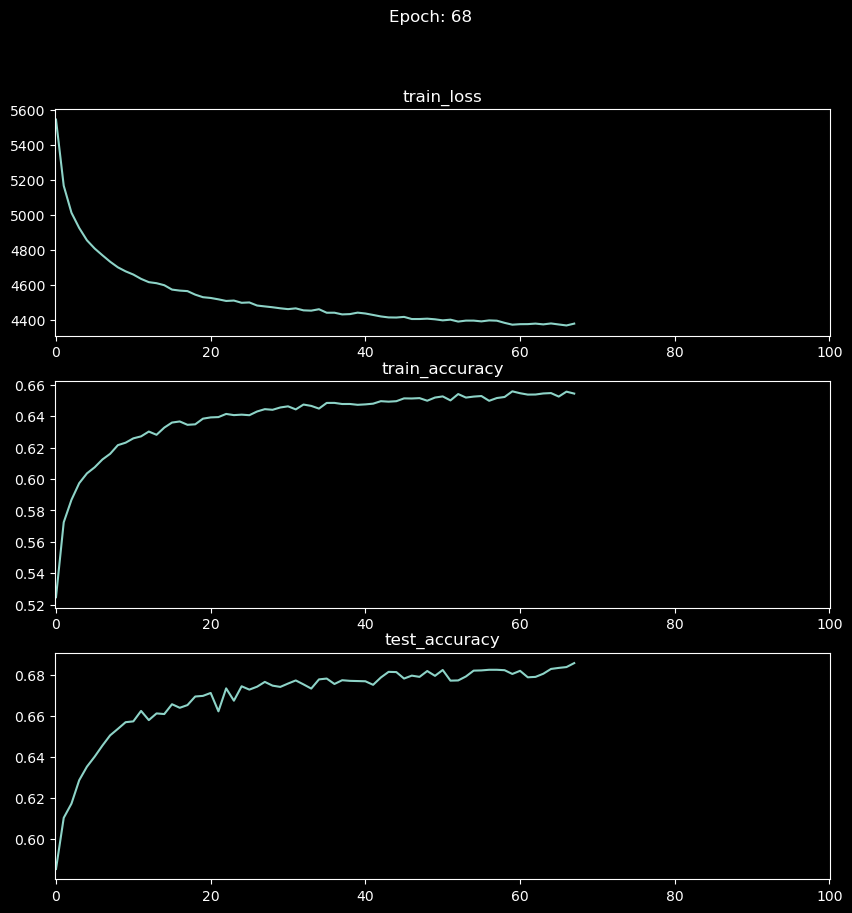

KeyboardInterrupt: 

In [11]:
epochs = 100

for epoch in (range(epochs)):

    train_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch_idx, (tokens_tensor, segments_tensors, attention_tensor, y) in enumerate(train_loader): #tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        tokens_tensor, segments_tensors, attention_tensor, y = tokens_tensor.to(device), segments_tensors.to(device), attention_tensor.to(device), y.to(device)
        pred = model(tokens_tensor, segments_tensors, attention_tensor)
        loss = lossFn(pred, y)
        # print(loss.item())
        train_loss += loss.item()
        train_accuracy += torch.sum(F.softmax(pred, dim=1).argmax(axis=1) == y).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_accuracy /= len(train_loader.dataset)


    model.eval()
    with torch.no_grad():
        for batch_idx, (tokens_tensor, segments_tensors, attention_tensor, y) in enumerate(test_loader): #tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            tokens_tensor, segments_tensors, attention_tensor, y = tokens_tensor.to(device), segments_tensors.to(device), attention_tensor.to(device), y.to(device)
            pred = model(tokens_tensor, segments_tensors, attention_tensor)
            test_accuracy += torch.sum(F.softmax(pred, dim=1).argmax(axis=1) == y).item()


    test_accuracy /= len(test_loader.dataset)

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    if len(history['test_accuracy']) and test_accuracy >= max(history['test_accuracy']):
        torch.save(state, f"{model_folder}/best.pth")

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)

    #########################################
    clear_output(wait=True)
    fig, axs = plt.subplots(len(history),1,figsize=(10,10))
    fig.suptitle(f"Epoch: {epoch+1}")
    for i, key in enumerate(history.keys()):
        ax = axs[i]
        ax.set_xlim(-0.1, epochs+0.1)
        ax.set_title(key)

        ax.plot(history[key])
    plt.show()
    #########################################

    torch.save(history, f"{model_folder}/history.pth")
    torch.save(state, f"{model_folder}/latest.pth")
    
    ##########################################


In [ ]:
# vocab_size, embedding_dim, hidden_dim = len(vocab), 6, 4
# model = LSTM_entailer(vocab_size, embedding_dim, hidden_dim).to(device)

# lossFn = torch.nn.CosineEmbeddingLoss(margin=0).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# history = {
#     "train_loss": [],
#     "train_accuracy": [],
#     "test_accuracy": []
# }

In [ ]:
# epochs=20
# for epoch in range(epochs):

#     train_loss = 0
#     train_accuracy = 0
#     test_accuracy = 0

#     model.train()
#     for i, (sentence1, sentence2, y) in tqdm(train_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(train_df)):
#         sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
#         sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
#         y = torch.as_tensor(y).view(-1).to(device)
#         out1, out2 = model(sentence1, sentence2)

#         pred = F.cosine_similarity(out1, out2)
#         loss = lossFn(out1, out2, y)

#         train_loss += loss.item()
#         train_accuracy += (y == 2*(pred>=0)-1).item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     train_loss /= len(train_df)
#     train_accuracy /= len(train_df)

#     ## Testing stuff ##

#     model.eval()
#     for i, (sentence1, sentence2, y) in tqdm(test_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(test_df)):
#         sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
#         sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
#         y = torch.as_tensor(y).view(-1).to(device)
#         out1, out2 = model(sentence1, sentence2)

#         pred = F.cosine_similarity(out1, out2)
#         test_accuracy += (y == 2*(pred>=0)-1).item()

#     test_accuracy /= len(test_df)

#     ###################

#     state = {
#         'epoch': epoch,
#         'state_dict': model.state_dict(),
#         'optimizer': optimizer.state_dict()
#     }

#     if len(history['test_accuracy']) and test_accuracy >= max(history['test_accuracy']):
#         torch.save(state, f"{model_folder}/best.pth")

#     history['train_loss'].append(train_loss)
#     history['train_accuracy'].append(train_accuracy)
#     history['test_accuracy'].append(test_accuracy)
    
#     #########################################
#     clear_output(wait=True)
#     fig, axs = plt.subplots(len(history),1,figsize=(10,10))

#     for i, key in enumerate(history.keys()):
#         ax = axs[i]
#         ax.set_xlim(-0.1, epochs+0.1)
#         ax.set_title(key)

#         ax.plot(history[key])
#     plt.show()
#     #########################################

#     torch.save(history, f"{model_folder}/history.pth")
#     torch.save(state, f"{model_folder}/latest.pth")
    
#     ##########################################

# Model Loading and Testing

Using cache found in /home/unnithan/.cache/torch/hub/huggingface_pytorch-transformers_main


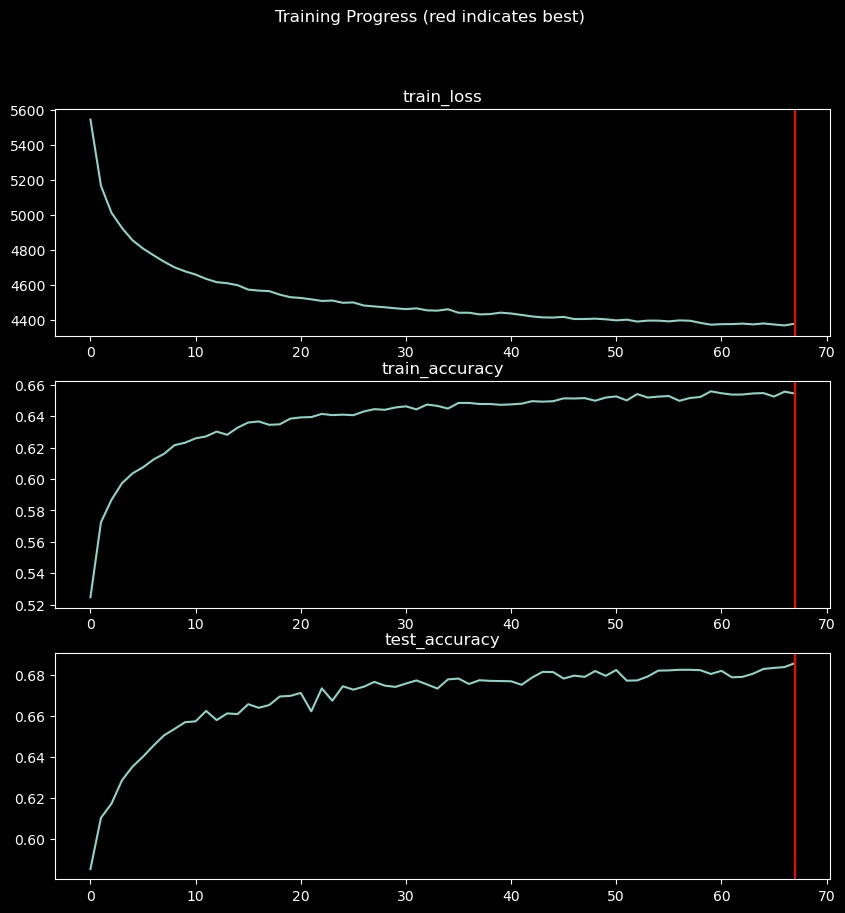

In [12]:
state = torch.load(f"{model_folder}/best.pth")
history = torch.load(f"{model_folder}/history.pth")

model = BertModel().to(device)
model.load_state_dict(state['state_dict'])

fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

plt.suptitle("Training Progress (red indicates best)")
plt.savefig('figs/Training Progress.jpg')

In [ ]:
# state = torch.load(f"{model_folder}/best.pth")
# history = torch.load(f"{model_folder}/history.pth")

# vocab_size, embedding_dim, hidden_dim = len(vocab), 6, 4
# model = LSTM_entailer(vocab_size, embedding_dim, hidden_dim).to(device)
# model.load_state_dict(state['state_dict'])

# fig, axs = plt.subplots(len(history),1,figsize=(10,10))
# test_best = state['epoch']

# for i, key in enumerate(history.keys()):
#     ax = axs[i]
#     ax.set_title(key)

#     ax.plot(history[key])
#     ax.axvline(test_best, color='red')

# plt.suptitle("Training Progress (red indicates best)")
# plt.savefig('figs/Training Progress.jpg')

In [ ]:
max(history['test_accuracy'])

0.683969465648855

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      3237
           1       0.67      0.62      0.65      3219
           2       0.68      0.79      0.73      3368

    accuracy                           0.69      9824
   macro avg       0.69      0.68      0.68      9824
weighted avg       0.69      0.69      0.68      9824



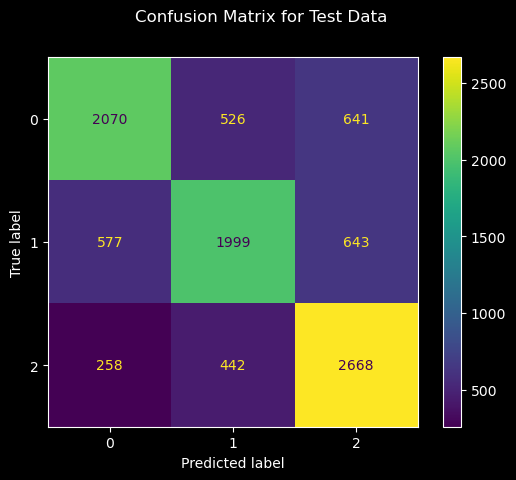

In [13]:
# Confusion matrix and accuracies

y_test = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch_idx, (tokens_tensor, segments_tensors, attention_tensor, y) in enumerate(test_loader): #tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        tokens_tensor, segments_tensors, attention_tensor, y = tokens_tensor.to(device), segments_tensors.to(device), attention_tensor.to(device), y.to(device)
        pred = model(tokens_tensor, segments_tensors, attention_tensor)

        y_test.extend(y.tolist())
        y_pred.extend(torch.exp(pred).argmax(axis=1).tolist())

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.suptitle('Confusion Matrix for Test Data')
plt.savefig('figs/Confusion Matrix for Test Data.jpg')

In [ ]:
# # Test Statistics

# predictions = []

# model.eval()
# for i, (sentence1, sentence2, y) in tqdm(test_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(test_df)):
#     sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
#     sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
#     y = torch.as_tensor(y).view(-1).to(device)
#     out1, out2 = model(sentence1, sentence2)

#     pred = F.cosine_similarity(out1, out2)
#     predictions.append(pred.item())

# predictions = np.array(predictions)
# y_pred = (predictions>=0)*2-1
# y_test = test_df['y'].to_numpy()

# print(classification_report(y_test, y_pred))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# plt.suptitle('Confusion Matrix for Test Data')
# plt.savefig('figs/Confusion Matrix for Test Data.jpg')